# P3 - Neural Networks in PyTorch

In [ ]:
import numpy as npb
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # this ensures that the mean pixel value is 0 and the standard deviation is 1
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

In [3]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [4]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Q: What does the Transform do?
A: Helps you transform the data into a representation usable by a NN. Adjust it to the needs of your loaded data, your model and the task you want to achieve.

In [5]:
train_dataset_no_transform = datasets.MNIST('./data', train=True, download=True)
train_dataset_no_transform[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

### Extra Example: Creating your own (custom) Dataset:

In [6]:
# Define your own Dataset
from torch.utils.data import Dataset


# Derive from torch.utils.data.Dataset, implement init, len and getitem
class CustomDataset(Dataset):
    def __init__(self):
        # Dataloading, Transformations, etc. handled here
        # Called once when creating the dataset
        pass

    def __len__(self):
        # Needs to return the total length of samples of the dataset
        pass

    def __getitem__(self, idx):
        # returns the sample of given index
        pass

custom_dataset = CustomDataset()

### Wrapping the Dataset in a DataLoader
Dataset = Container of the Data

DataLoader = Helper that delivers the data to the model


_Hint: explicitly import the classes you need to get better IntelliSense support_

In [31]:
# Set random seed for reproducibility
torch.manual_seed(302); np.random.seed(302)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [34]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Explorative Data Analysis

In [9]:
image_batch, label_batch = next(iter(train_loader))

image_batch.shape, label_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [10]:
torch.mean(image_batch), torch.std(image_batch)

(tensor(-0.0180), tensor(0.9793))

Let's plot some training images

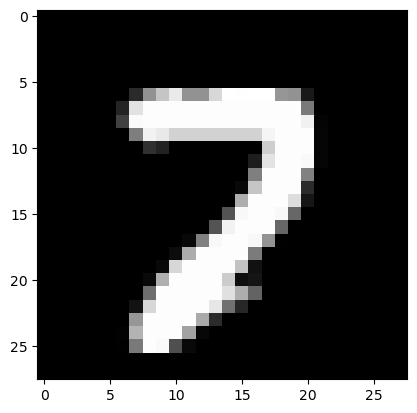

In [11]:
plt.imshow(image_batch[0, 0, :, :].numpy(), cmap='gray')

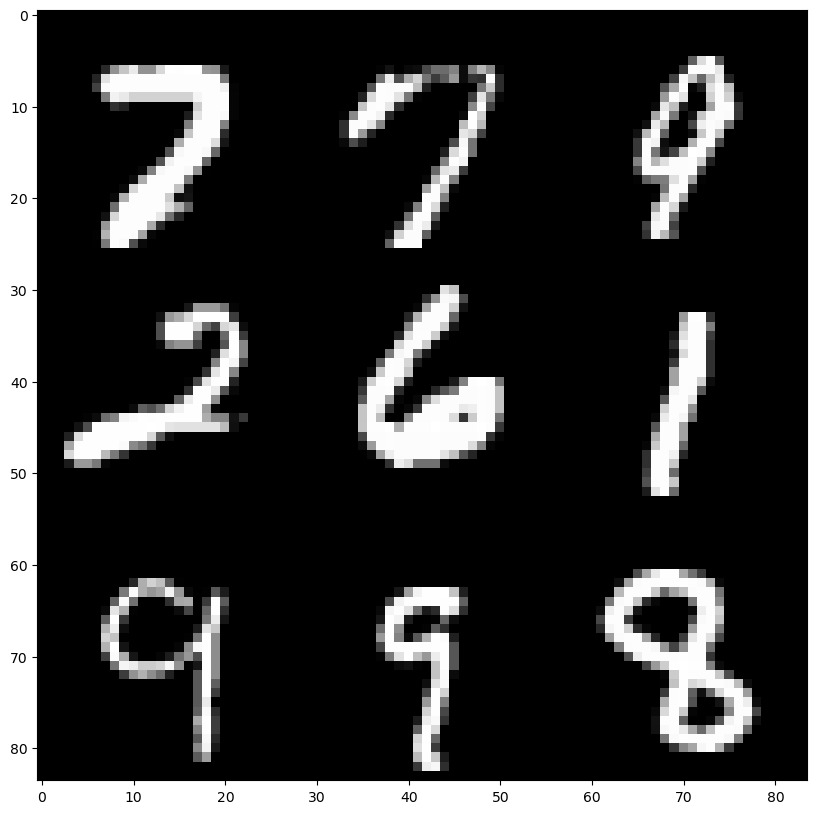

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(image_batch[:9, 0, :, :]
           .reshape(3, 3, 28, 28)
           .permute(0, 2, 1, 3)
           .reshape(28*3, 28*3), cmap='gray')
plt.show()

In [13]:
label_batch[:9]

tensor([7, 7, 9, 2, 6, 1, 9, 9, 8])

Let's check the distribution of labels in the training set:

In [14]:
train_dataset.targets.shape

torch.Size([60000])

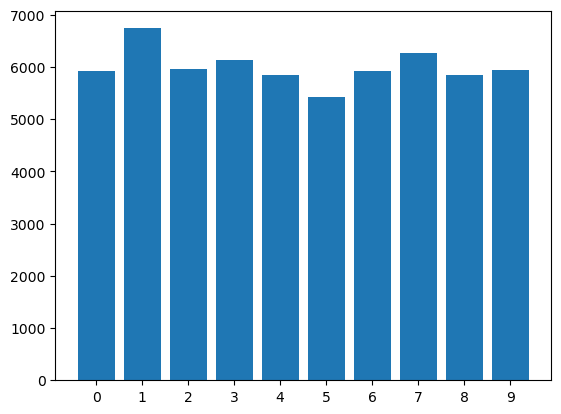

In [15]:
counts = train_dataset.targets.bincount()

plt.bar(range(len(counts)), counts, tick_label=range(len(counts)))
plt.show()

## Feed Forward Neural Networks in `PyTorch`

![](nn.png "Example of a Feed Forward Neural Network")

Credit: https://alexlenail.me/NN-SVG/index.html

Each hidden neuron computes its output as a *weighted sum* of the neuron's inputs (plus a bias), followed by a *non-linear activation function* $h(x)$

$$ z = h \left( \sum_{i=1}^N w_i x_i + b \right) $$

where $x_1,\dots,x_N \in \mathbb{R}$ are the inputs to the neuron, and $w_1,\dots,w_N \in \mathbb{R}$, $b \in \mathbb{R}$ are their corresponding weights and biases.

## Defining the Network

Feed-forward neural network with 3 hidden layers in PyTorch:

In [16]:
class NeuralNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(in_features=28*28, out_features=128) 
      self.fc2 = nn.Linear(in_features=128, out_features=128, bias=False)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
      # Flatten the data (B, 1, 28, 28) => (B, 784), where B is the batch size
      x = torch.flatten(x, start_dim=1)

      # Pass data through 1st fully connected layer
      x = self.fc1(x)
      # Apply ReLU non-linearity
      x = F.relu(x)

      # Pass data through 2nd fully connected layer
      x = self.fc2(x)
      # Apply ReLU non-linearity
      x = F.relu(x)

      # Pass data through 3rd fully connected layer
      x = self.fc3(x)

      # Before passing x to the (log) softmax function,
      # the values in x are called *logits*.

      # Apply softmax to x (in log domain)
      log_probs = F.log_softmax(x, dim=1)

      return log_probs

The softmax function is given by

$$ \operatorname{softmax}(\mathbf{x})_k = \frac{\exp(x_k)}{\sum_{i=1}^D \exp(x_i)} $$

where $\mathbf{x} \in \mathbb{R}^D$.

In [17]:
class NeuralNet2(nn.Module):
    def __init__(self):
      super(NeuralNet2, self).__init__()
      self.stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=28*28, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10)
      )

    def forward(self, x):
      # Flatten the data (B, 1, 28, 28) => (B, 784), where B is the batch size
      x = self.stack(x)
      
      # Apply softmax to x (in log domain)
      log_probs = F.log_softmax(x, dim=1)

      return log_probs

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NeuralNet().to(device)
print(model)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [19]:
model2 = NeuralNet2().to(device)
print(model2)

NeuralNet2(
  (stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [20]:
for name, p in model.named_parameters():
    print(f"{name:15s} | {str(tuple(p.shape)):10s} | requires_grad={p.requires_grad}")


fc1.weight      | (128, 784) | requires_grad=True
fc1.bias        | (128,)     | requires_grad=True
fc2.weight      | (128, 128) | requires_grad=True
fc3.weight      | (10, 128)  | requires_grad=True
fc3.bias        | (10,)      | requires_grad=True


Let $\mathbf{x} \in \mathbb{R}^{28 \times 28}$ be the input image and $y \in \{0,\dots,9\}$ the label.

Our network $f_{\mathbf{\theta}}(\mathbf{x})$ models

$$f_{\mathbf{\theta}}(\mathbf{x}) = \left( \log p(y = 0 \, | \, \mathbf{x}), \ \log p(y = 1 \, | \, \mathbf{x}), \ \dots \ \log p(y = 9 \, | \, \mathbf{x}) \right)^\top$$

In [21]:
x = image_batch[:1]
print(f'Input shape: {x.shape}')

log_probs = model(x)
print(f'Ouptput shape: {log_probs.shape}')
print(f'Model output: {log_probs}')

Input shape: torch.Size([1, 1, 28, 28])
Ouptput shape: torch.Size([1, 10])
Model output: tensor([[-2.3440, -2.4475, -2.4167, -2.2658, -2.3307, -1.9715, -2.2772, -2.5964,
         -2.0768, -2.4573]], grad_fn=<LogSoftmaxBackward0>)


In [22]:
probs = torch.exp(log_probs)
print(probs)
print(torch.sum(probs))

tensor([[0.0959, 0.0865, 0.0892, 0.1037, 0.0972, 0.1392, 0.1026, 0.0745, 0.1253,
         0.0857]], grad_fn=<ExpBackward0>)
tensor(1., grad_fn=<SumBackward0>)


In [23]:
pred = torch.argmax(probs, dim=1)
pred

tensor([5])

## The Loss Function

In classification problems, it is common to use the *Negative-Log-Likelihood-Loss* (`NLLLoss`) (or, equivalently, the `CrossEntropyLoss`).
In `pytorch`, they differ just in what they expect as input:
+ `NLLLoss`: Expects log-probabilities as input
+ `CrossEntropyLoss`: Expects logits as input

In [24]:
true_y = label_batch[:1]
true_y

tensor([7])

In [25]:
log_probs

tensor([[-2.3440, -2.4475, -2.4167, -2.2658, -2.3307, -1.9715, -2.2772, -2.5964,
         -2.0768, -2.4573]], grad_fn=<LogSoftmaxBackward0>)

In [26]:
loss_fn = nn.NLLLoss()

loss_fn(log_probs, true_y)

tensor(2.5964, grad_fn=<NllLossBackward0>)

In [27]:
-log_probs[0, true_y[0]]

tensor(2.5964, grad_fn=<NegBackward0>)

## Training the model

We will use *Stochastic Gradient Descent* (`SGD`) to minimize the `NLLLoss` (i.e., to train the model).

The _optimizer_ will be covered in more detail next practical session.

In [28]:
learning_rate = 0.01
num_epochs = 5

model = NeuralNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

losses = []
for epoch in range(num_epochs):
    print('-'*20, f'Epoch {epoch}', '-'*20)
    # Train one epoch
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        log_probs = model(data)
        loss = loss_fn(log_probs, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Train Epoch {epoch} | Loss: {loss.item()}')
    
    print(f'\nAverage train loss in epoch {epoch}: {np.mean(losses[-len(train_loader):])}')
    
    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            log_probs = model(data)
            test_loss += F.nll_loss(log_probs, target, reduction='sum').item()  # sum up batch loss
            pred = torch.argmax(log_probs, dim=1)  # get the index of the max log-probability
            correct += (pred == target).sum().item()

    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * avg_correct:.0f}%)\n')

-------------------- Epoch 0 --------------------
Train Epoch 0 | Loss: 2.3230817317962646
Train Epoch 0 | Loss: 1.8909168243408203
Train Epoch 0 | Loss: 1.2519012689590454
Train Epoch 0 | Loss: 0.6419106721878052
Train Epoch 0 | Loss: 0.7948104739189148
Train Epoch 0 | Loss: 0.5333600640296936
Train Epoch 0 | Loss: 0.3369109034538269
Train Epoch 0 | Loss: 0.35207706689834595
Train Epoch 0 | Loss: 0.2320072054862976
Train Epoch 0 | Loss: 0.32993194460868835

Average train loss in epoch 0: 0.8068984019826216
Test set: Average loss: 0.3442, Accuracy: 9000/10000 (90%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Loss: 0.22267937660217285
Train Epoch 1 | Loss: 0.522866427898407
Train Epoch 1 | Loss: 0.32968267798423767
Train Epoch 1 | Loss: 0.2636615037918091
Train Epoch 1 | Loss: 0.3347753584384918
Train Epoch 1 | Loss: 0.4620390236377716
Train Epoch 1 | Loss: 0.13334916532039642
Train Epoch 1 | Loss: 0.1511203795671463
Train Epoch 1 | Loss: 0.264237642288208
Train E

## Question: What is the loss of a model that predicts $p_{\theta}(y \, | \, \mathbf{x}) = 0.1$ for all $y \in \{0,\dots,9\}$ and for all $\mathbf{x}$?

In [29]:
-np.log(0.1)

np.float64(2.3025850929940455)

## Plot Loss Curve

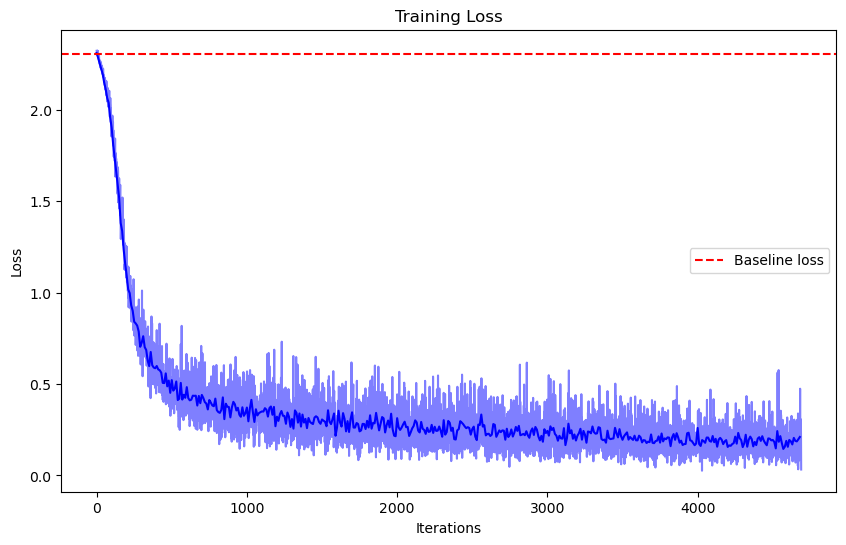

In [30]:
losses_smoothed = np.array(losses).reshape(-1, 10).mean(axis=1) # average every 10 batch losses
steps = np.arange(len(losses))

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, 'b', alpha=0.5)
plt.plot(steps[::10], losses_smoothed, 'b')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# plot horizontal line at baseline loss
plt.axhline(y=-np.log(0.1), color='r', linestyle='--', label='Baseline loss')
plt.legend(loc='right')
plt.show()